## Asset pricing

Here we are going to solve some easy asset pricing tasks in a Black-Scholes framework

### 0. Assummptions

1) The stock price follows geometric Brownian motion:
$$
\begin{equation}
S_t = \mu S_t dt + \sigma S_t dW_t
\end{equation}
$$

2) The parameters are: $S_0 = 100$, $\sigma=0.1$, $r=0.05$, $\mu=0.1$ 

3) We are going to consider a European type claim which pays $X_T = \sqrt{S_T}$ at time $T$. Moreover, we are going to analyze with $T=2$.

### 1. Simulate 500 trajectories and plot 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from typing import Callable, Optional

In [2]:
def plot_trajectories(length: float, num_splits: int, num_traj: int,  
                      y_label: str,
                      process_name: str,
                      sim_func: Callable,
                      mean_func: Optional[Callable] = None,
                      **sim_func_kwargs) -> None:
    """
    just a simple plotting function
    """
    
    plt.figure(figsize=(13, 7))
    for traj in range(num_traj):
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 sim_func(length, num_splits, **sim_func_kwargs))
        
        
    if mean_func is not None:
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 mean_func(np.arange(0, length, length/(num_splits + 1))),
                 label="true mean")
        plt.legend()
    
    plt.xlabel("$t$")
    plt.ylabel(y_label)
    plt.title(f"Simulated trajectories of a {process_name}")
    plt.xlim(0, length)
    
    plt.show()

In [3]:
def create_path_BM(length: float, num_splits: int) -> np.ndarray:
    """
    length: float -- last moment of time to be simulated
    num_splits: int -- number of increments to create, 
    increment is \Delta W_t and it is sample from N(0, T/N)
    
    return trajectory of brownian motion
    """
    increments = np.random.normal(loc=0, 
                                  scale=(length/num_splits) ** 0.5, 
                                  size=num_splits)
    
    trajectory = np.zeros(num_splits+1)
    trajectory[1:] = np.cumsum(increments)
    return trajectory

In [6]:
def Black_Scholes_SDE(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, s_0: int = 1,
                     order: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    S_t = np.zeros(num_splits + 1)
    S_t[0] = s_0
    
    for i in range(1, num_splits+1):
        S_t[i] = S_t[i-1] + mu * S_t[i-1]* delta + sd * S_t[i-1] * increments[i-1]
        
        if order == 2:
            S_t[i] += 0.5 * (sd ** 2) * S_t[i-1] * (increments[i-1] ** 2 - delta)
    
    return S_t

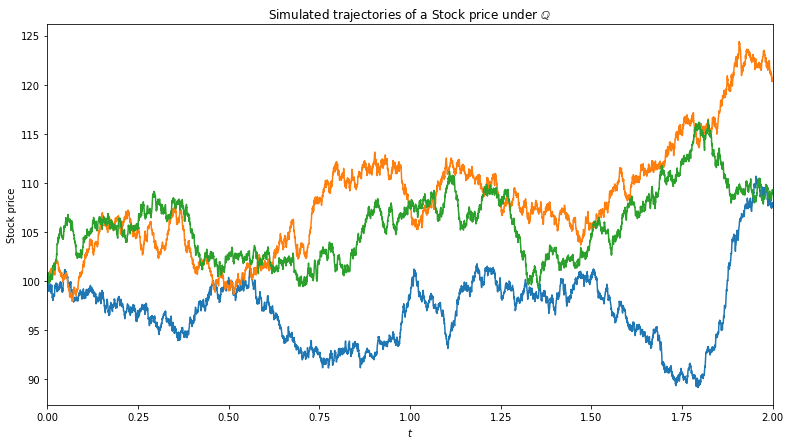

In [66]:
np.random.seed(15)

plot_trajectories(length=2, 
                  num_splits=5000, 
                  num_traj=3,
                  y_label="Stock price", 
                  process_name="Stock price under $\mathbb{Q}$",
                  sim_func=Black_Scholes_SDE,
                  s_0=100, mu=0.05, sd=0.1       
                 )

In [61]:
np.random.seed(15)
stock_price_trajectories = np.c_[[Black_Scholes_SDE(2, 5000, 0.05, 0.1, 100, 100) for _ in range(500)]]

### 2. Calculate arbitrage free price of X_0 via simulations and via theoretical expected values

Theoretical price is:
$$
X_0 = e^{-2r}\mathbb{E}^{\mathbb{Q}}[\sqrt{S_2}|S_0=100]
$$

Here expectation is taken with respect to martingale measure $\mathbb{Q}$. If we consider measure $\mathbb{Q}$ then we can write down:
$$
\log(\sqrt{S_2/S_0}) = (r - \sigma^2/2) + 0.5 \sigma W^{\mathbb{Q}}_2 \Rightarrow 
\log(\sqrt{S_2}) | S_0 \sim \mathcal{N}((r - \sigma^2/2) + \log(\sqrt{S_0}), 0.5\sigma^2)
$$

Thus we can compute expectation by exponentiating the logarithm and using the formula for the log-normal distribution:
$$
X_0 = e^{-2r}\mathbb{E}^{\mathbb{Q}}[\sqrt{S_2}|S_0=100] = 
e^{-2r} \exp( (r - \sigma^2/2) + \log(\sqrt{S_0}) + \sigma^2/4)=
e^{-r - \sigma^2/4}\sqrt{S_0} = 10e^{-0.0525}
$$

In [63]:
print(f"Theoretical price: {10*np.exp(-0.0525)}")

Theoretical price: 9.488543210558012


In [65]:
print(f"Simulated price: {np.sqrt(stock_price_trajectories[:, -1]).mean() * np.exp(-0.1)}")

Simulated price: 9.494602523385733


### 3. How many shares should be in the replicating portfolio at time $t$? Plot 3 trajectories of shares in the portfolio 

Now we have to price $X_t$. Following the same steps we have:
$$X_t = e^{-2r}\mathbb{E}^{\mathbb{Q}}[\sqrt{S_2}|S_t]$$
$$
\log(\sqrt{S_2/S_t}) = 0.5(r - \sigma^2/2)t + 0.5 \sigma W^{\mathbb{Q}}_2 \Rightarrow 
\log(\sqrt{S_2}) | S_t \sim \mathcal{N}(0.5(r - \sigma^2/2)t + \log(\sqrt{S_t}), 0.25\sigma^2t)
$$
$$
X_t = e^{-rt}\mathbb{E}^{\mathbb{Q}}[\sqrt{S_2}|S_t] = 
e^{-rt}  \exp(0.5(r - \sigma^2/2)t + \log(\sqrt{S_t}) + \sigma^2t/8)= 
e^{-0.5rt-\sigma^2t/8}\sqrt{S_t}
$$

Then by delta-hedging the amount of shares in the portfolio $y_t$ is:
$$
y_t = \cfrac{\partial X_t}{\partial S_t} = e^{-0.5rt-\sigma^2t/8}\cfrac{1}{2\sqrt{S_t}}
$$

In [76]:
def delta_hedge(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, s_0: int = 1,
                     order: int = 1) -> np.ndarray:
    
    stock_price = Black_Scholes_SDE(length, num_splits, mu, sd, s_0, order)
    time = np.linspace(0, length, num_splits+1)
    
    hedge = np.exp(-(0.5 * mu + sd ** 2 / 8) * time) / (2 * np.sqrt(stock_price))
    
    return hedge

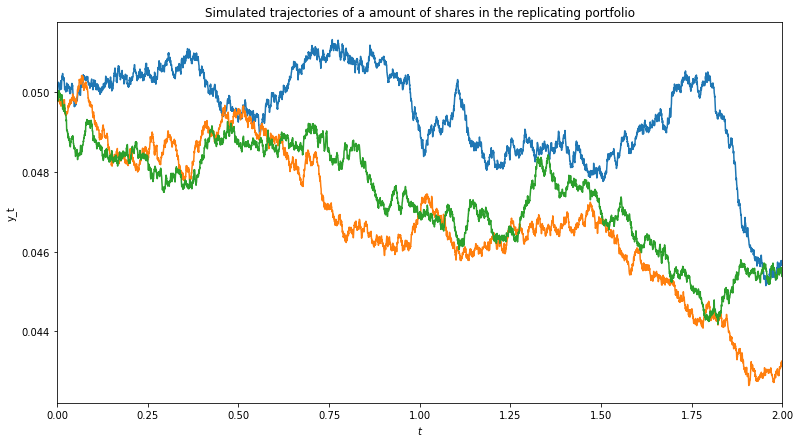

In [91]:
np.random.seed(15)

plot_trajectories(length=2, 
                  num_splits=5000, 
                  num_traj=3,
                  y_label='y_t',
                  process_name="amount of shares in the replicating portfolio",
                  sim_func=delta_hedge,
                  s_0=100, mu=0.05, sd=0.1       
                 )

### 4. Plot the trajectories of the replicating portfolio price

The amount of bonds in the potfolio $z_t$ is equal to:
$$
z_t = \cfrac{X_t - y_t S_t}{B_t}
$$

In [95]:
def derivative_price(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, s_0: int = 1,
                     order: int = 1):
    
    stock_price = Black_Scholes_SDE(length, num_splits, mu, sd, s_0, order)
    time = np.linspace(0, length, num_splits+1)
    
    derivative =  np.exp(-(0.5 * mu + sd ** 2 / 8) * time) * np.sqrt(stock_price)
    return derivative

In [124]:
def replicating_portfolio(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, s_0: int = 1,
                     order: int = 1, b_0: int = 100):
    
    stock_price = Black_Scholes_SDE(length, num_splits, mu, sd, s_0, order)
    
    time = np.linspace(0, length, num_splits+1)
    
    hedge = np.exp(-(0.5 * mu + sd ** 2 / 8) * time) / (2 * np.sqrt(stock_price))
    derivative =  np.exp(-(0.5 * mu + sd ** 2 / 8) * time) * np.sqrt(stock_price)
    bond_price = np.exp(mu * time) * b_0
    
    bonds_amount = (derivative - hedge * stock_price) / bond_price
    
    portfolio = hedge * stock_price + bonds_amount * bond_price
    
    return portfolio

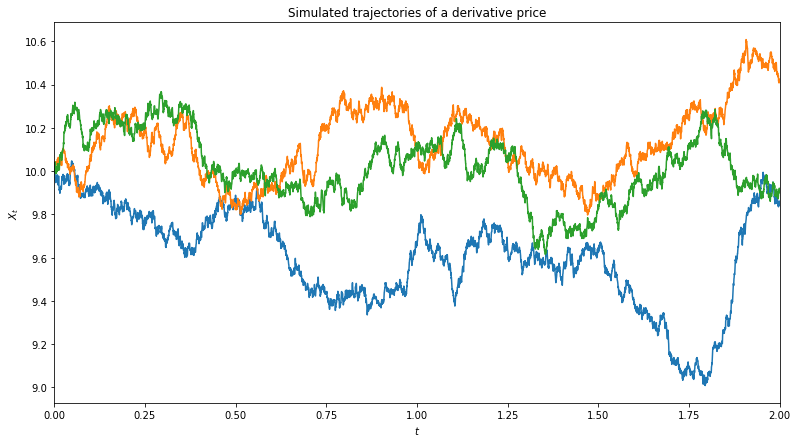

In [125]:
np.random.seed(15)

plot_trajectories(length=2, 
                  num_splits=5000, 
                  num_traj=3,
                  y_label='$X_t$',
                  process_name="derivative price",
                  sim_func=derivative_price,
                  s_0=100, mu=0.05, sd=0.1       
                 )

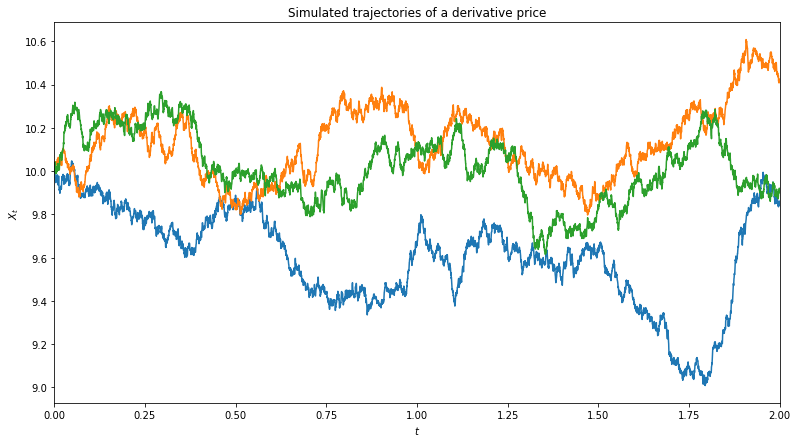

In [126]:
np.random.seed(15)

plot_trajectories(length=2, 
                  num_splits=5000, 
                  num_traj=3,
                  y_label='$X_t$',
                  process_name="derivative price",
                  sim_func=replicating_portfolio,
                  s_0=100, mu=0.05, sd=0.1       
                 )